In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

from features.utils.logger_config import logger
from features.utils.path_utils import FileLoader
from features.data_profiling.data_profiler import DataProfiler
from features.data_profiling.outlier_detection import OutlierDetection
from features.data_quality_validation.data_quality_checks import DataQualityChecks
from features.data_quality_validation.schema_definition import WINE_QUALITY_TYPE_SCHEMA, WINE_QUALITY_RANGE_SCHEMA
from features.data_quality_validation.schema_validation import SchemaValidation

In [2]:
# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

# Resolve path and load dataset
wine_path = "./datasets/wine_quality_corrupted.csv"
df = FileLoader.load_csv_with_delimiter(spark, wine_path, delimiter=",")

# Initialize components
data_checks = DataQualityChecks(df)
schema_validation = SchemaValidation(df)
outlier_detection = OutlierDetection(df)
data_profiler = DataProfiler(df)

logger.info("Dataset Preview:")
df.show(5)

25/04/04 01:39:08 WARN Utils: Your hostname, adonis-6.local resolves to a loopback address: 127.0.0.1; using 192.168.0.165 instead (on interface en0)
25/04/04 01:39:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/04 01:39:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


01:39:12 INFO: Dataset Preview:
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality| Id|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|    5.0|0.0|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|    5.0|1.0|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|    5.0|2.0|
|         11.2|            0.28|       0.56|

In [3]:
# Validate Schema
logger.info("Starting schema validation...")
column_check = schema_validation.validate_column_names(schema=WINE_QUALITY_TYPE_SCHEMA)
logger.info(f"Column Name Check Results: {column_check}")

type_check = schema_validation.validate_data_types(type_schema=WINE_QUALITY_TYPE_SCHEMA)
logger.info(f"Data Type Check Results: {type_check}")

schema_result = schema_validation.validate_ranges(range_schema=WINE_QUALITY_RANGE_SCHEMA)
logger.info(f"Schema Validation Result: {schema_result}")

01:39:13 INFO: Starting schema validation...
01:39:13 INFO: Column Name Check Results: {'missing_columns': [], 'extra_columns': []}
01:39:13 INFO: Data Type Check Results: {'fixed acidity': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'volatile acidity': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'citric acid': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'residual sugar': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'chlorides': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'free sulfur dioxide': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'total sulfur dioxide': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'density': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'pH': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'sulphates': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'alcohol': {'expected': 'FloatType()', 'actual': 'DoubleType()'}, 'quality': {'expected': 'FloatType()', 'actual': 'D

In [4]:
# Data Quality Checks
logger.info(f"Null Values Count: {data_checks.check_null_values()}")
logger.info(f"Duplicate Rows Count: {data_checks.check_duplicates()}")
logger.info("Data quality checks completed.")

01:39:14 INFO: Null Values Count: DataFrame[fixed acidity: bigint, volatile acidity: bigint, citric acid: bigint, residual sugar: bigint, chlorides: bigint, free sulfur dioxide: bigint, total sulfur dioxide: bigint, density: bigint, pH: bigint, sulphates: bigint, alcohol: bigint, quality: bigint, Id: bigint]
01:39:14 INFO: Duplicate Rows Count: 10
01:39:14 INFO: Data quality checks completed.


In [5]:
# Perform outlier checks
logger.info(f"Outliers based on Z-score: {outlier_detection.check_outliers_zscore()}")
logger.info(f"Outliers based on IQR: {outlier_detection.check_outliers_iqr()}")

# Data profiling step
statistics = data_profiler.generate_statistics()
print(statistics)

25/04/04 01:39:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


01:39:16 INFO: Outliers based on Z-score: {'fixed acidity': 6, 'volatile acidity': 5, 'citric acid': 1, 'residual sugar': 22, 'chlorides': 21, 'free sulfur dioxide': 14, 'total sulfur dioxide': 11, 'density': 3, 'pH': 5, 'sulphates': 21, 'alcohol': 8, 'quality': 6, 'Id': 0}
01:39:17 INFO: Outliers based on IQR: {'fixed acidity': 49, 'volatile acidity': 14, 'citric acid': 1, 'residual sugar': 122, 'chlorides': 85, 'free sulfur dioxide': 33, 'total sulfur dioxide': 51, 'density': 39, 'pH': 16, 'sulphates': 49, 'alcohol': 18, 'quality': 22, 'Id': 0}
Descriptive Statistics:
summary      fixed acidity    volatile acidity         citric acid     residual sugar            chlorides free sulfur dioxide total sulfur dioxide               density                pH          sulphates            alcohol            quality                Id
  count               1158                1158                1158               1158                 1158                1158                 1158             

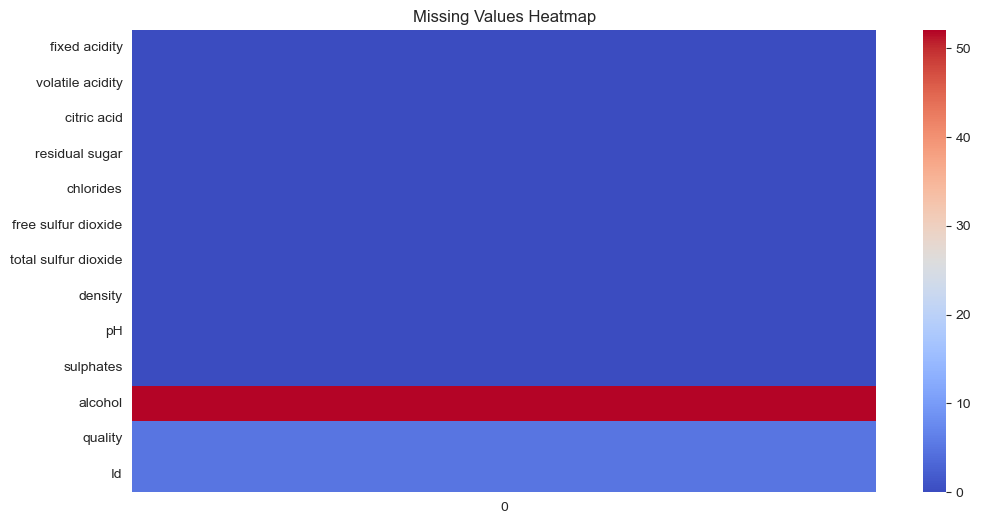

In [6]:
# Visualizing Missing Values
null_values = data_checks.check_null_values().toPandas()
plt.figure(figsize=(12, 6))
sns.heatmap(null_values.T, cbar=True, cmap='coolwarm').set_title('Missing Values Heatmap')  # Transpose for better readability
plt.show()

In [ ]:
# Histograms for All Features
plt.figure(figsize=(12, 6))
df.toPandas().hist(bins=30, figsize=(12, 6), edgecolor='black')
plt.suptitle('Histograms for All Features', fontsize=16)
plt.show()